In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import trange
import pickle

In [2]:
def spinson_independent_flip(opinions, spinson):
    opinions[spinson] = -1 if opinions[spinson] == 1 else 1
    
    return opinions

In [3]:
def spinson_conformity_flip(graphs, opinions, spinson, q):
    neighbours = []
    for graph in graphs:
        if len(list(graph.neighbors(spinson))) < q:
            neighbours.extend(list(graph.neighbors(spinson)))
        else:
            neighbours.extend(random.sample(list(graph.neighbors(spinson)), q))
    neighbours_opinions = [opinions[neighbour] for neighbour in neighbours]
    if len(set(neighbours_opinions)) == 1:
        opinions[spinson] = neighbours_opinions[0]

    return opinions

In [4]:
def q_voter_simulation(graphs, p, q, iterations):
    magnetization = []
        
    opinions = [1] * len(graphs[0].nodes())
    for i in range(iterations):
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly? 
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip(graphs, opinions, spinson, q)

        magnetization.append(sum(opinions)/len(graphs[0]))
        
    return magnetization

In [5]:
def calculate_average_magnetization_final(graphs, ps, q, mc):
    magnetizations = []
    for j in trange(len(ps)):  
        magnetization = np.zeros(mc)
        for i in range(mc):    
            magnetization = magnetization + q_voter_simulation(graphs, ps[j], q, mc)
        magnetizations.append(magnetization[-1]/mc)
        
    return magnetizations

## Created networks

In [6]:
G = nx.read_gpickle('neighbourhood')
K = nx.barabasi_albert_graph(len(G), 1)
L = nx.star_graph(len(G)-1)

In [7]:
with open('neighbourhood_position.pickle', 'rb') as handle:
    pos = pickle.load(handle)

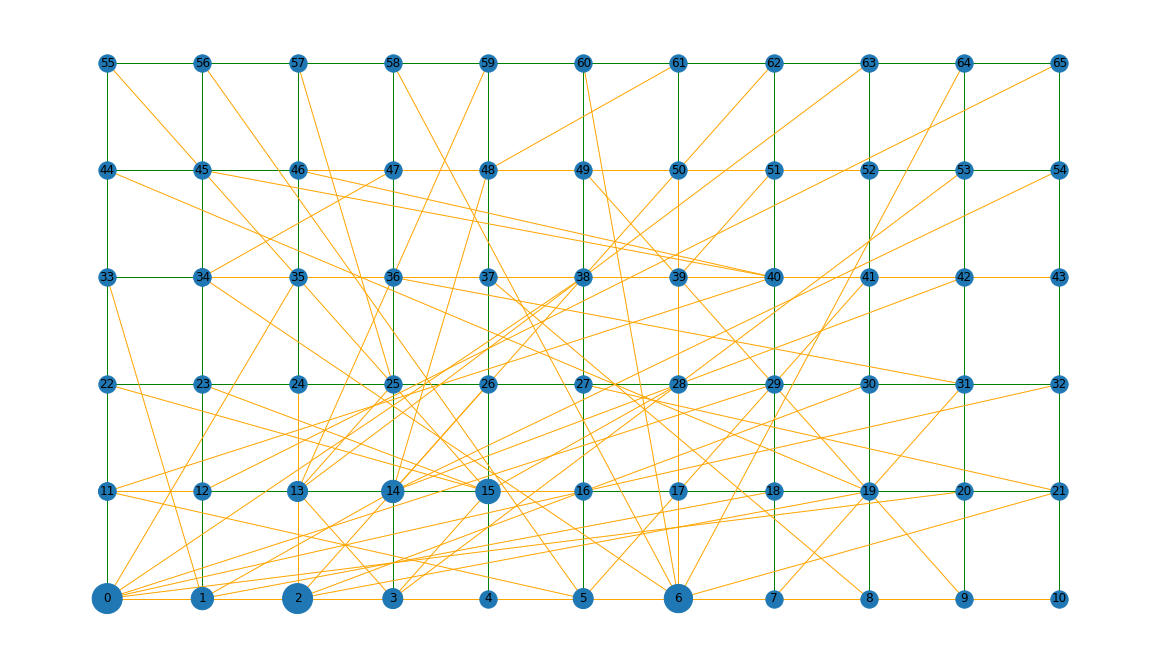

In [8]:
plt.figure(figsize=(16, 9))
colors = ['orange']*len(G)
nx.draw(G, edge_color=['green']*len(G), pos=pos)
nx.draw(K, edge_color=colors, pos=pos, with_labels=True, node_size=[v * 100 for v in dict(K.degree).values()])
#nx.draw(L, edge_color=['yellow']*len(G), pos=pos)

In [9]:
graphs = [G, K, L]

In [10]:
def q_voter_simulation(graphs, p, q, iterations):
    magnetization = [1]
    counter = 0
        
    opinions = [1] * len(graphs[0].nodes())
    for i in range(iterations):
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly?
                counter += 1
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip(graphs, opinions, spinson, q)

        magnetization.append(sum(opinions)/len(graphs[0]))
        
    return magnetization, counter

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]


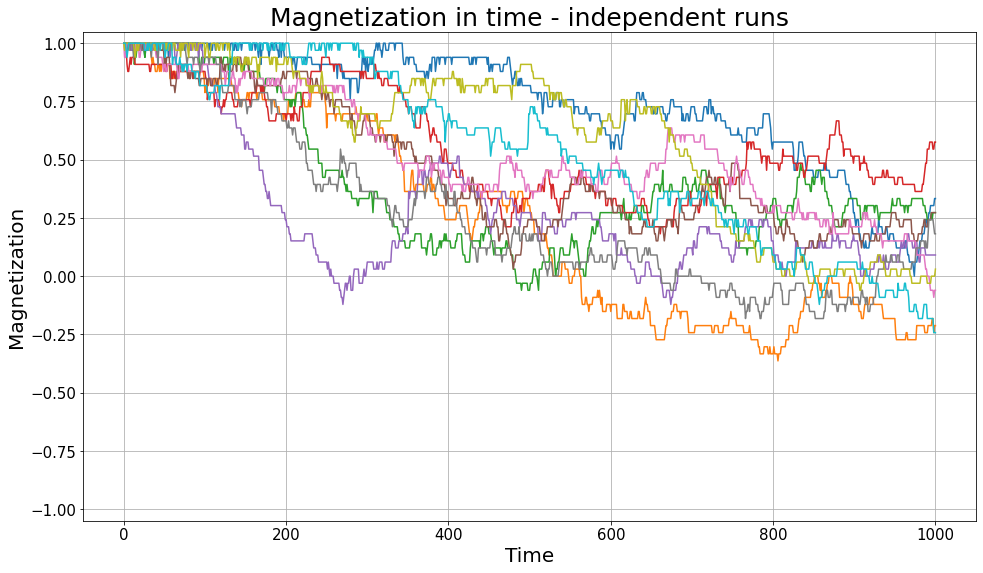

In [11]:
plt.figure(figsize=(16, 9))
for _ in trange(10):
    x, y = q_voter_simulation(graphs, 1/100, 4, 1000)
    plt.plot(x)
plt.ylim(-1.05, 1.05)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title('Magnetization in time - independent runs', fontsize=25)
plt.grid()

Layer of neighbourhood - rectangular (2d grid layout) network, which represents a node and their neighbours. <font color='green' size="2"><b> Done </b></font>

Layer of social interaction - Barabasi Albert Graph with different number of newly connected nodes (confirmed) <font color='green' size="2"><b> Done </b></font>

Layer of social media - how it can affect other nodes? Can the strength of such an influence be different in each step of iteration?

Layer of temporary connection - what about some different unusual meetings in the network?

Additional layer - vertical connection with the same index of a node, without horizontal connection. This graph could represent utility of each node. It means some nodes from the beginning wouldn't be able to change their opinion i.e. at the beginning of simulation their coefficient of e.g. attitude to environemntal issues or income are too small to change (buy) EV. Social network couldn't help in this situation. Neighbours can't affect for opinion of a node.